In [1]:
from functools import reduce
import numpy as np
from constants import *
from green_function import *
#import holoviews
from scipy import linalg as sla
import matplotlib as mp
plt.style.use('seaborn')		# Setting the plotting style
mp.rcParams['figure.figsize'] = (15, 10)  # Setting the size of the plots
import numpy.linalg as la 


N = 100

def evolution_operator(hamiltonians, T):
    n = len(hamiltonians)
    exps = [sla.expm(-1j * h * T / n) for h in hamiltonians]
    return reduce(np.matmul, exps)


def calculate_finite_spectrum(periods, hamiltonians):
    energies = []
    for T in periods:
        U = evolution_operator(hamiltonians, T)
        phases = np.angle(la.eigvals(U))
        phases = np.sort(np.abs(phases))
        ev = np.sort([(-1) ** n * val for n, val in enumerate(phases)])
        energies.append(ev)
    return np.array(energies).real


def calculate_bands(momenta, hamiltonians_k, T):
    energies = []
    for k in momenta:
        hamiltonians = [h_k(k) for h_k in hamiltonians_k]
        U = evolution_operator(hamiltonians, T)
        phases = np.angle(la.eigvals(U))
        phases = np.sort(np.abs(phases))
        ev = np.sort([(-1) ** n * val for n, val in enumerate(phases)])
        energies.append(ev)
    return np.array(energies).real

In [2]:
def onsite(mu=mu):
    return -mu * s_z


def hopping(t=t, delta=delta):
    return -t * s_z +  1j * delta * s_y

In [3]:
periods = np.linspace(0.2 / t, 5 / t, 100)
momenta = np.linspace(-2*np.pi, 2*np.pi,100)

h_1 = Hamiltonian(d,N,onsite(mu=0*t),hopping())
h_2 = Hamiltonian(d,N,onsite(mu=1*t),hopping())


energies = calculate_finite_spectrum(periods, [h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()])
spectrum = np.array([calculate_bands(momenta, [h_1.k_space_hamiltonian, h_2.k_space_hamiltonian], T) for T in periods])

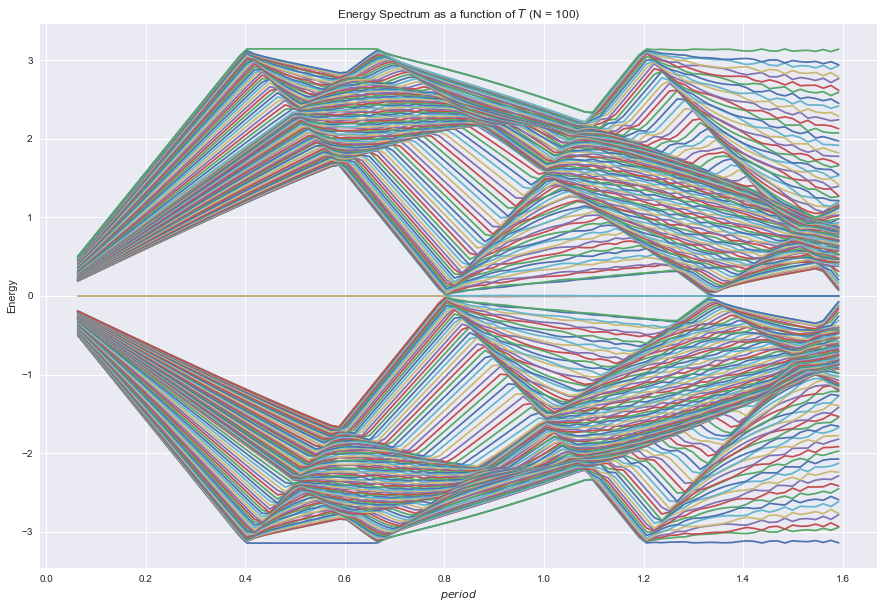

In [4]:
plt.title("Energy Spectrum as a function of $T$ (N = {})".format(N))
for i in range(d*N):
    plt.plot(periods,energies[:,i])
plt.ylabel('Energy')
plt.xlabel('$period$')
plt.show()

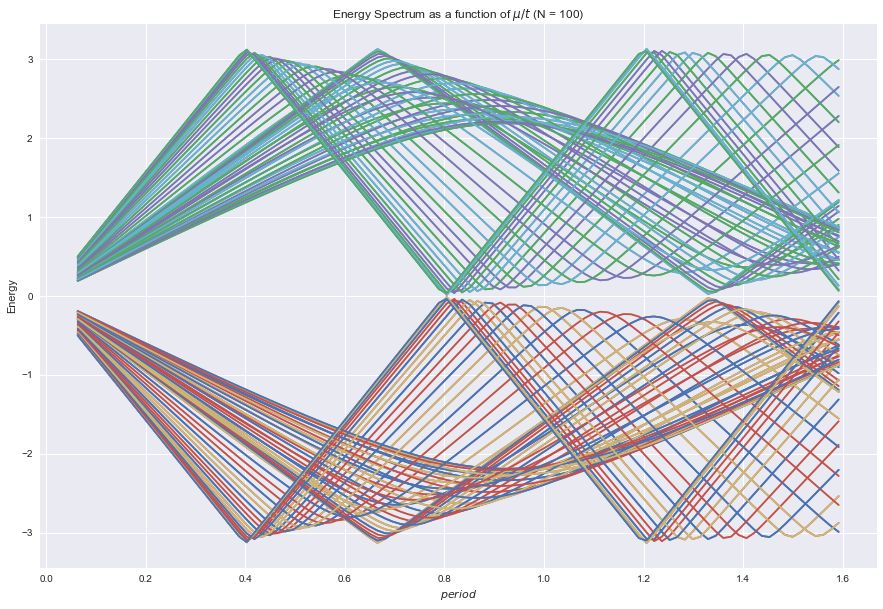

In [5]:
plt.title("Energy Spectrum as a function of $\mu/t$ (N = {})".format(N))
for i in range(100):
    plt.plot(periods,spectrum[:,i])
plt.ylabel('Energy')
plt.xlabel('$period$')
plt.show()
#plt.savefig('interesting bulk spectrum.png')

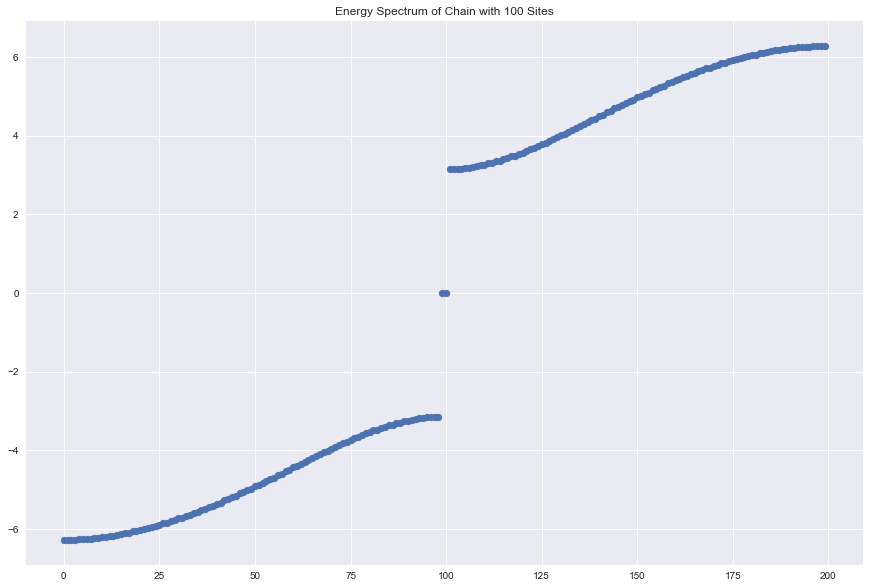

In [6]:
def plot_spectrum(Hmat):
    evals,evecs = la.eigh(Hmat)
    evals = evals.real
    plt.scatter(np.arange(len(evals)),evals)
    plt.title('Energy Spectrum of Chain with {} Sites'.format(N))
    plt.show()
    
plot_spectrum(h_1.lattice_hamiltonian())

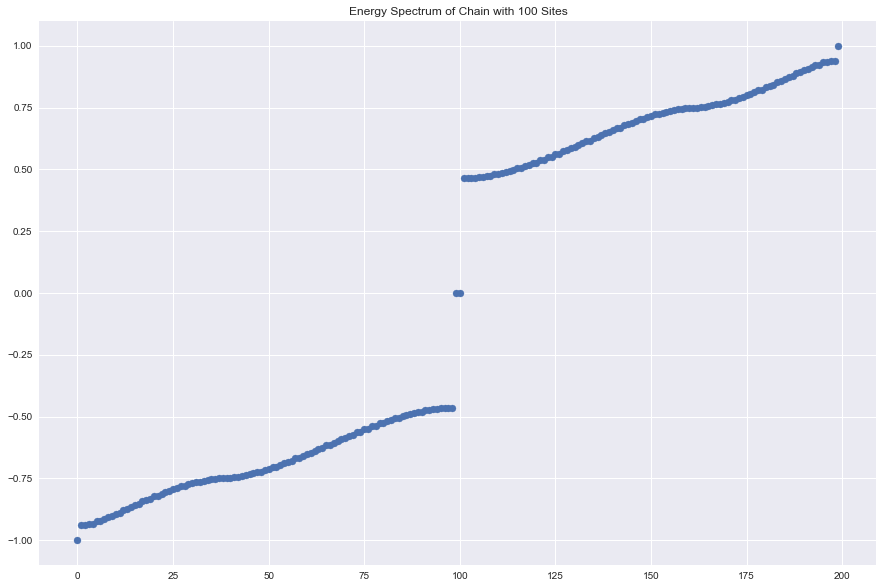

In [7]:
#Delta = 0.5*t
#h_1 = Hamiltonian(d,N,onsite(mu=0*t),hopping(delta=Delta))
#h_2 = Hamiltonian(d,N,onsite(mu=1*t),hopping(delta=Delta))
U = evolution_operator([h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()],T=0.5)
h_f = 1j * sla.logm(U)/np.pi
plot_spectrum(h_f)

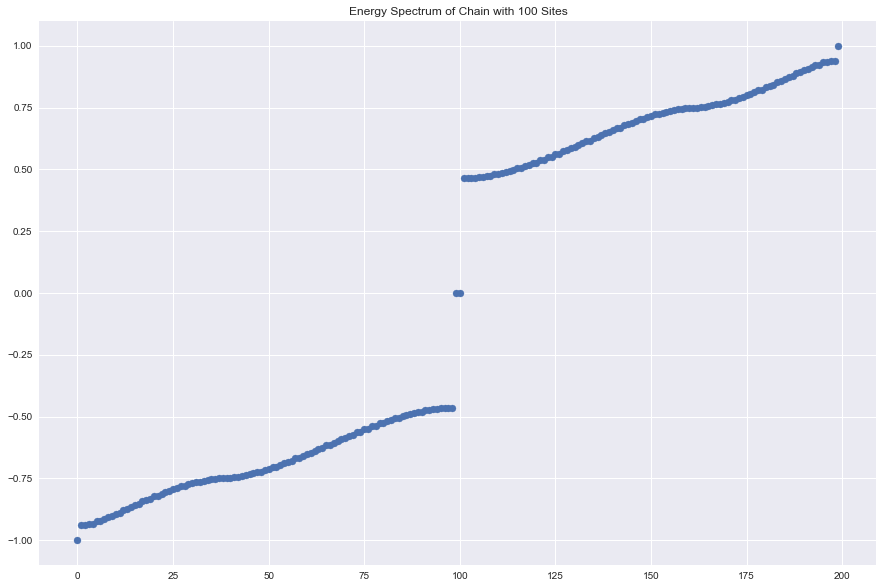

In [8]:
plot_spectrum(h_f)

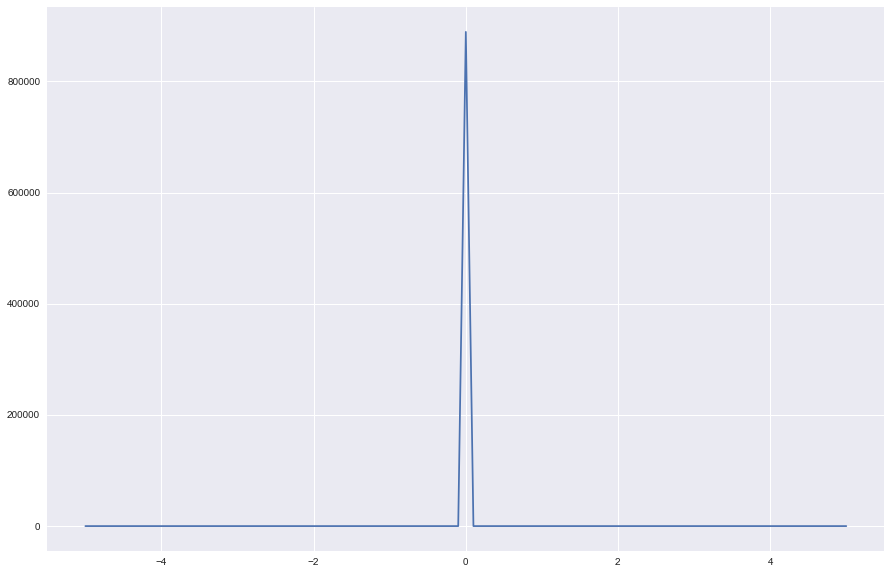

In [9]:
'''G = [np.trace(la.inv(w-0.000001j-h_f))[0:d,0:d].imag for w in range(100)]
plt.plot(G)
'''
ldos = []
var_E = np.linspace(-5,5,101)
for E in var_E:
    G = la.inv((E-0.000001j)*np.eye(h_1.d*h_1.N)-h_1.lattice_hamiltonian())
    G_L_img = G[0:d,0:d].imag
    ldos.append(np.trace(G_L_img))
plt.plot(var_E,ldos)

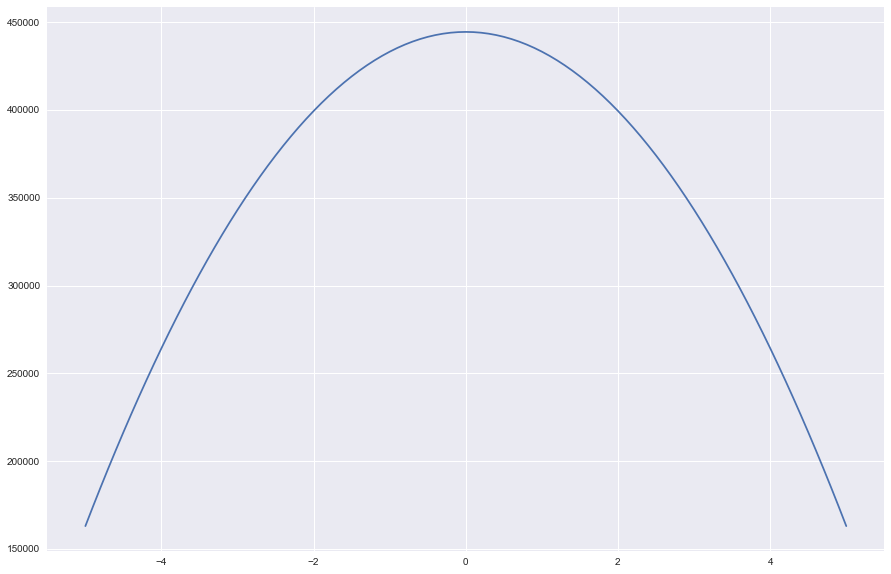

In [10]:
#الكود بلوك ده مش شغال
ldos = []
var_mu = np.linspace(-5,5,101)
for m in var_mu:
    h = Hamiltonian(d,N,onsite(mu=m),hopping())
    G = la.inv((-0.000001j)*np.eye(h.d*h.N)-h.lattice_hamiltonian())
    G_L_img = G[0:d,0:d].imag
    ldos.append(G_L_img[0,0])
plt.plot(var_E,ldos)

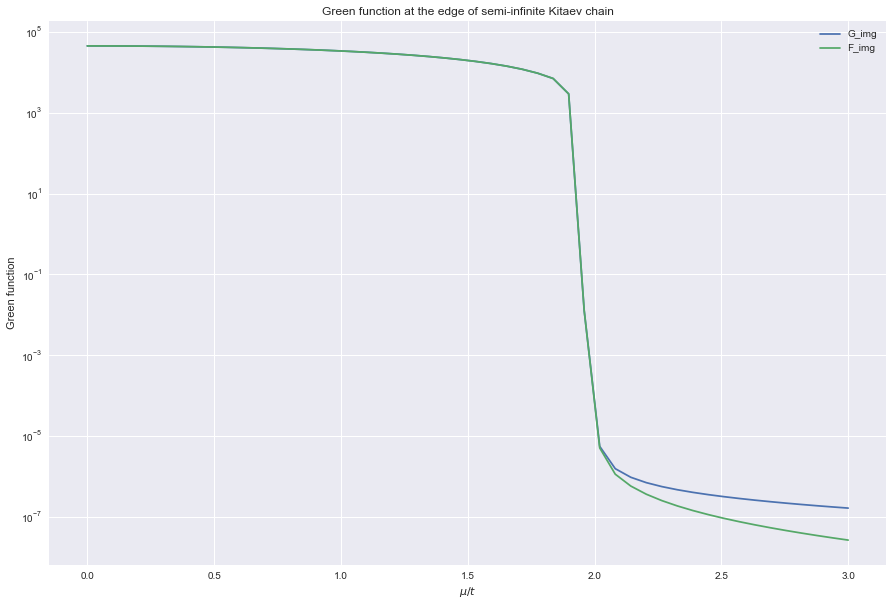

In [11]:
var_mu = np.linspace(0*t,3*t,50)
F_img = np.zeros([len(var_mu)])
G_img = np.zeros([len(var_mu)])
for i in range(len(var_mu)):
    hamiltonian = Hamiltonian(d,N,onsite(mu=var_mu[i]),hopping())
    G_img[i] = -1*np.array([la.inv(1j*0.00001*np.eye(d*N)-hamiltonian.lattice_hamiltonian())[0,0].imag])
    F_img[i] = 1*np.array([la.inv(1j*0.00001*np.eye(d*N)-hamiltonian.lattice_hamiltonian())[0,1].imag])
plt.title("Green function at the edge of semi-infinite Kitaev chain")
plt.plot(var_mu/t,G_img, label='G_img')
plt.plot(var_mu/t,F_img,label='F_img')
#plt.plot(var_mu/t,G_img-F_img,label = 'G_img-F_img')
plt.ylabel('Green function')
plt.xlabel('$\mu/t$')
plt.yscale('log')
plt.legend()
plt.show()

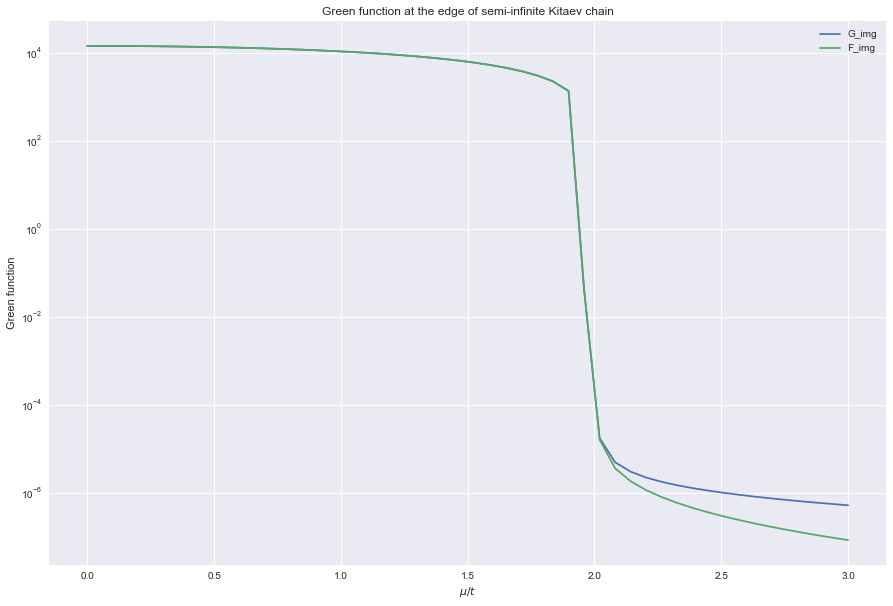

In [12]:
def recursive_green_function(z,G,mu_a):
    y = z
    u = -mu_a * s_z
    V = -t * s_z + 1j * delta * s_y
    V_dagger = -t * s_z - 1j * delta * s_y
    G = la.inv(z*s_0 - u - np.matmul(V_dagger,np.matmul(G,V)))
    K=G
    yield G
    yield from recursive_green_function(z=y,G=K,mu_a=mu_a)


var_mu = np.linspace(0*t,3*t,50)
F_img = np.zeros([len(var_mu)])
G_img = np.zeros([len(var_mu)])
G=[]
G_0=[]
for i in range(len(var_mu)):
    G_0.append(la.inv(0.00001j * t * s_0 - var_mu[i] * s_z))
    G.append(recursive_green_function(z=0.00001j*t,mu_a=var_mu[i],G=G_0[i]))
    for n in range(N-1):
        next(G[i])
    G_img[i] = -1*np.array([next(G[i])[0,0].imag])
    F_img[i] = -1*np.array([next(G[i])[0,1].imag])
    #the above line takes value from the N+1 site. you should modify the code later!!!
plt.title("Green function at the edge of semi-infinite Kitaev chain")
plt.plot(var_mu/t,G_img, label='G_img')
plt.plot(var_mu/t,F_img,label='F_img')
#plt.plot(var_mu/t,G_img-F_img,label = 'G_img-F_img')
plt.ylabel('Green function')
plt.xlabel('$\mu/t$')
plt.yscale('log')
plt.legend()
plt.show()

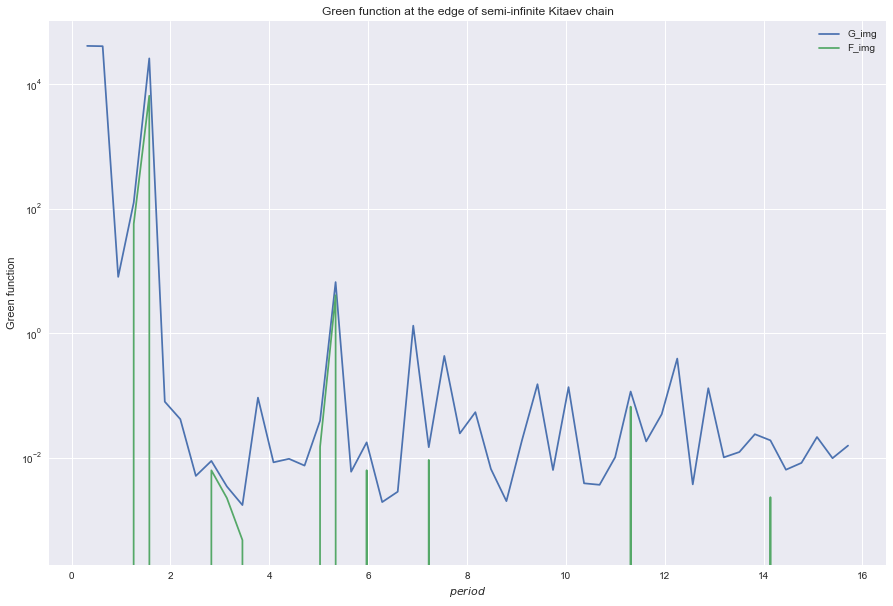

In [13]:
var_time = np.linspace(0.1*t,5*t,50)
F_img = np.zeros([len(var_time)])
G_img = np.zeros([len(var_time)])
for i in range(len(var_time)):
    U = evolution_operator([h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()],T=var_time[i])
    h_f = 1j * sla.logm(U)/np.pi
    G_img[i] = -1*np.array([la.inv(1j*0.00001*np.eye(len(h_f))-h_f)[0,0].imag])
    F_img[i] = -1*np.array([la.inv(1j*0.00001*np.eye(len(h_f))-h_f)[0,1].imag])
plt.title("Green function at the edge of semi-infinite Kitaev chain")
plt.plot(var_time,G_img, label='G_img')
plt.plot(var_time,F_img,label='F_img')
#plt.plot(var_mu/t,G_img-F_img,label = 'G_img-F_img')
plt.ylabel('Green function')
plt.xlabel('$period$')
plt.yscale('log')
plt.legend()
plt.show()

logm result may be inaccurate, approximate err = 3.6661193901877393e-13
2000


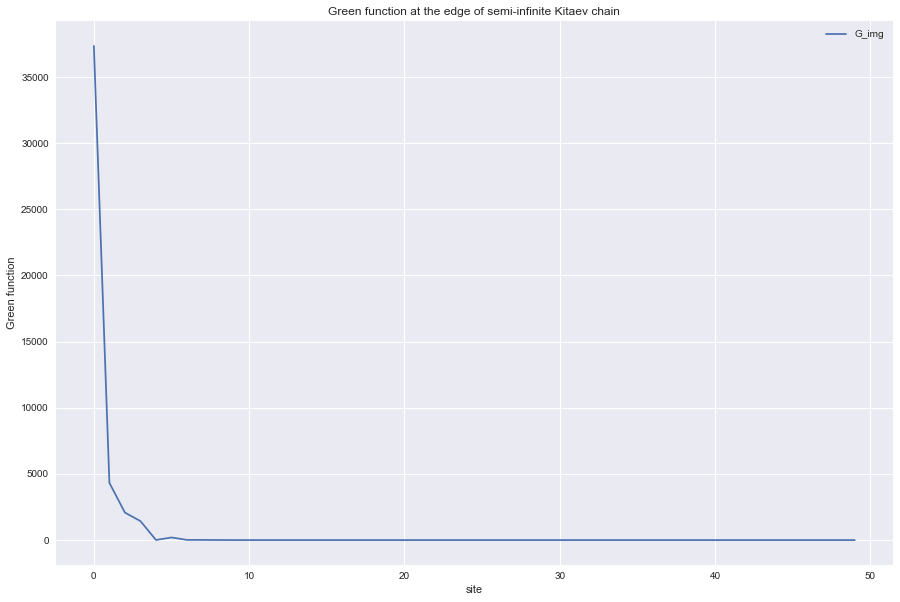

In [14]:
N = 1000
h_1 = Hamiltonian(d,N,onsite(mu=0*t),hopping())
h_2 = Hamiltonian(d,N,onsite(mu=1*t),hopping())

U = evolution_operator([h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()],T=0.5)
h_f = 1j * sla.logm(U)/np.pi
#plot_spectrum(h_f)
#F_img[i] = -1*np.array([la.inv(1j*0.00001*np.eye(len(h_f))-h_f)[0,1].imag])



index = np.arange(50)
G_pos = np.array(la.inv(1j*0.00001*np.eye(len(h_f))-h_f))
G_neg = np.array(la.inv(-1j*0.00001*np.eye(len(h_f))-h_f))
G_OTE = (G_pos - G_neg)/2
print(len(G_OTE))
f_OTE = [G_OTE[0+i*d,1+i*d].imag for i in index]
plt.title("Green function at the edge of semi-infinite Kitaev chain")
plt.plot(index,f_OTE, label='G_img')
#plt.plot(index,F_img,label='F_img')
#plt.plot(var_mu/t,G_img-F_img,label = 'G_img-F_img')
plt.ylabel('Green function')
plt.xlabel('site')
#plt.yscale('log')
plt.legend()
plt.show()

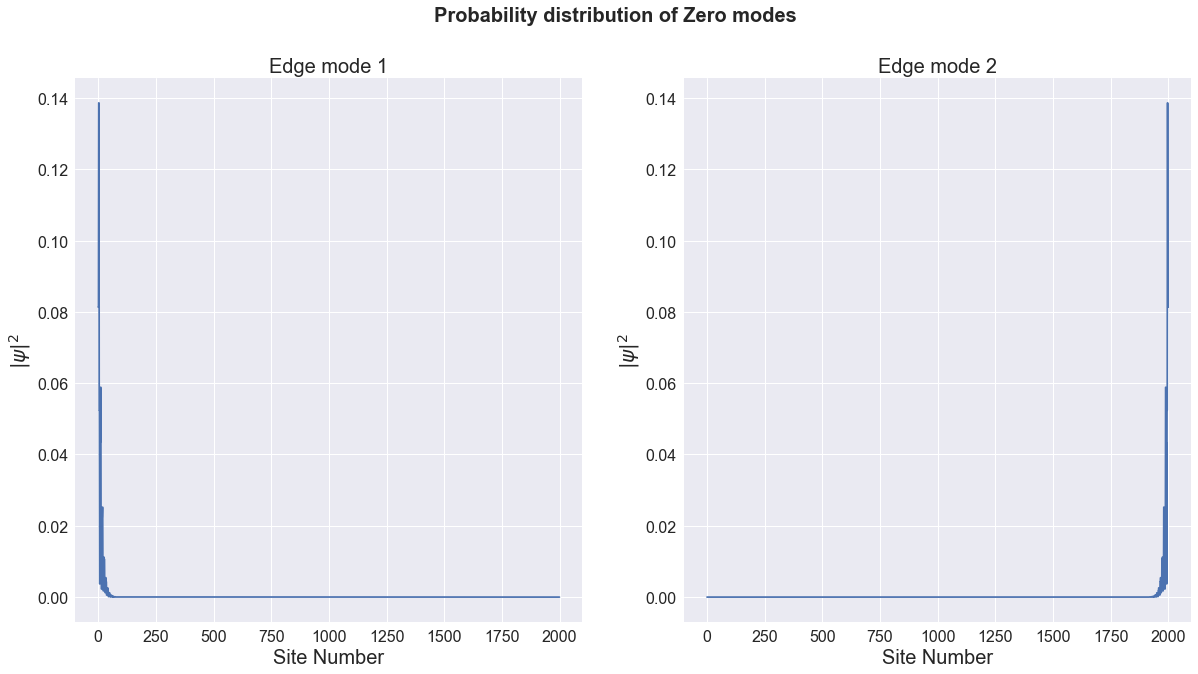

In [15]:
e_threshold = 1E-6	 # Threshold for finding zero eigenstates
#e_threshold = 0.0005	 # Threshold for finding zero eigenstates
params = {
't' : 2.0,               # Nearest neighbor hopping
'Delta' : 2.0,           # Superconducting pairing term
'mu' : 0.0               # Chemical potential
}

# Extract the indices of energy modes close to zero
def check_zeromodes(evals):
    nzmodes = 0
    zmodes_ind = np.where(abs(evals) >= 1-e_threshold)[0]
    return zmodes_ind,len(zmodes_ind)

def plot_zeromodes(evals,evecs):

    
    zmodes_ind,cnt_zmodes = check_zeromodes(evals)
    if cnt_zmodes > 0:
        fig,ax = plt.subplots(1,cnt_zmodes,figsize=(20, 10))
        fig.suptitle('Probability distribution of Zero modes',fontsize=20, fontweight='bold')
        for cnt in range(cnt_zmodes):
            ax1 = ax[cnt]
            ax1.plot(np.abs(evecs[:,zmodes_ind[cnt]])**2)
            ax1.set_title('Edge mode {}'.format(cnt+1),fontsize=20)
            ax1.set_xlabel('Site Number',fontsize=20)
            ax1.set_ylabel('$|\psi|^2$',fontsize=20)
            #ax1.text(0.43, 0.95, param_info, transform=ax1.transAxes, fontsize=16,
        #verticalalignment=('top', bbox=dict(boxstyle="square",facecolor="white"))
            ax1.tick_params(axis='both', which='major', labelsize=16)
        #plt.savefig('Edge_modes_Kitaev.pdf')
        plt.show()
        
evals,evecs = la.eigh(h_f)
plot_zeromodes(evals,evecs)

In [16]:
len(h_f)

2000

1000


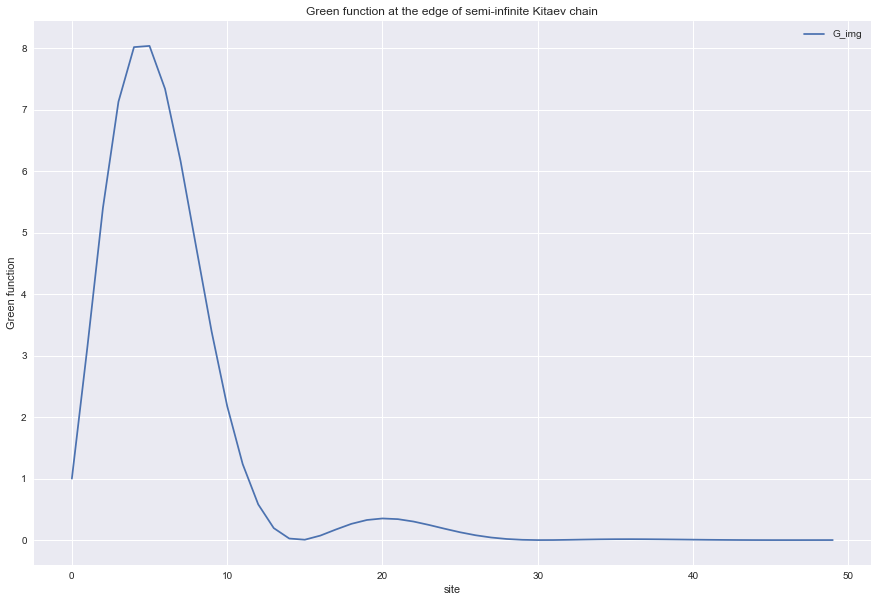

In [17]:
N = 500
delta = 0.1*t

h_1 = Hamiltonian(d,N,onsite(mu=2.0*t),hopping(delta=delta))
h_2 = Hamiltonian(d,N,onsite(mu=1.9*t),hopping(delta=delta))

U = evolution_operator([h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()],T=0.5)
h_f = 1j * sla.logm(U)/np.pi
#plot_spectrum(h_f)
#F_img[i] = -1*np.array([la.inv(1j*0.00001*np.eye(len(h_f))-h_f)[0,1].imag])

#h_f = h_2.lattice_hamiltonian()

index = np.arange(50)
G_pos = np.array(la.inv(1j*0.00001*np.eye(len(h_f))-h_f))
G_neg = np.array(la.inv(-1j*0.00001*np.eye(len(h_f))-h_f))
G_OTE = (G_pos - G_neg)/2
print(len(G_OTE))
f_OTE = [G_OTE[0+i*d,1+i*d].imag/G_OTE[0,1].imag for i in index]
plt.title("Green function at the edge of semi-infinite Kitaev chain")
plt.plot(index,f_OTE, label='G_img')
#plt.plot(index,F_img,label='F_img')
#plt.plot(var_mu/t,G_img-F_img,label = 'G_img-F_img')
plt.ylabel('Green function')
plt.xlabel('site')
#plt.yscale('log')
plt.legend()
plt.show()

In [18]:
x = 2
#print(h_f[0:x*d,0:x*d])
import pandas as pd
df = pd.DataFrame(h_f[0:x*d,0:x*d])
print(df)

                            0                           1  \
0 -4.026491e-03+1.126552e-15j -4.324193e-16-6.203329e-17j   
1 -2.173041e-16+3.868094e-16j  4.026491e-03-8.530642e-17j   
2  3.483715e-01-3.690281e-05j -6.610978e-03-7.873266e-04j   
3  6.610978e-03-7.873266e-04j -3.483715e-01-3.690281e-05j   

                            2                           3  
0  3.483715e-01+3.690281e-05j  6.610978e-03+7.873266e-04j  
1 -6.610978e-03+7.873266e-04j -3.483715e-01+3.690281e-05j  
2  2.496718e-02+4.220800e-16j -9.748080e-17+8.360303e-17j  
3 -4.727359e-17-1.703356e-16j -2.496718e-02+3.564347e-16j  


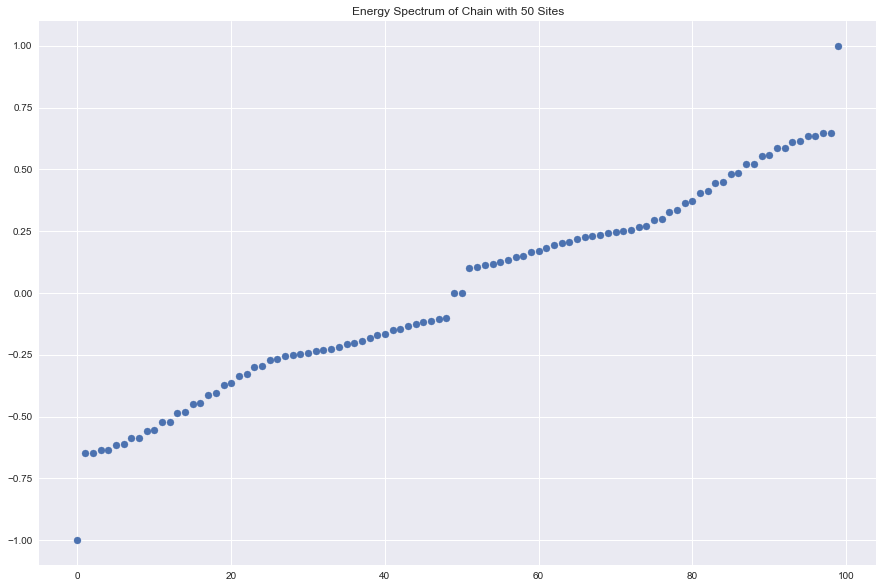

In [64]:
N = 50
Delta = 1.0*t
h_1 = Hamiltonian(d,N,onsite(mu=1*t),hopping(delta=Delta))
h_2 = Hamiltonian(d,N,onsite(mu=4*t),hopping(delta=Delta))
U = evolution_operator([h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()],T=0.5)
h_f = 1j * sla.logm(U)/np.pi
plot_spectrum(h_f)